#Cognitive-Machine-Learning
This is a new algorithm that I'm currently developing, focusing on adaptive learning rather than on a mathematically rigorous process for determining the next decision. The idea is to create a vast network of neurons, each with a specific function that determines how useful a piece of information is to the network. Each function serves as an imitation of cognitive processes, with meanings similar to Jungian cognitive functions:

*   t - Thinking: Determines if certain information is needed.
*   f - Feeling: Checks if information abides by the neuron’s rules.
*   s - Sensing: Attempts to map information to an internal representation.
*   n - Intuition: Maps the internal representation to information.


In this codebase, we will cover the following components:

1. Graph: A standard graph data structure to facilitate information processing.
2. NeuronFactory: Creates basic neuron structures that process information at the lowest level of abstraction.
3. BrainBuilder: Connects the basic neuron architecture into a brain-like structure.
4. TraverseBrain: Serves as our learning algorithm, processing the constructed graph.
5. IksOksGame: Acts as a test and learn function to train the model.

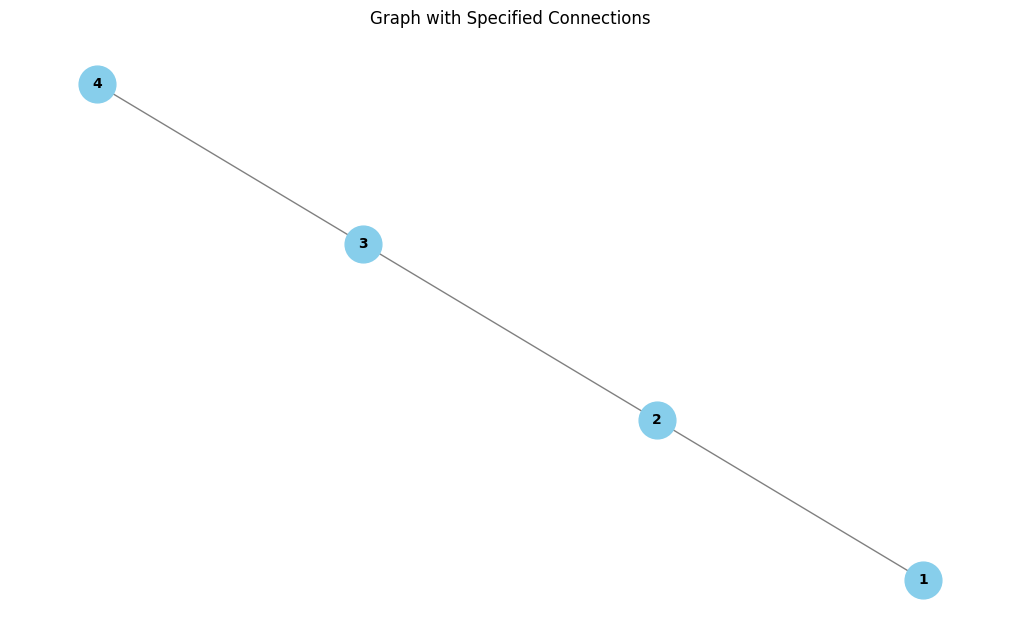

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

#Standard Graph data structure
class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.current = 0

    def add_node(self, signal, intensity, cf):
        """Add a node with specific attributes and return the node ID."""
        self.current += 1
        #signal represents the boardstate, intensity the prevelance of the node streinght and cf - the cognitive function witch will be applyed to node
        self.nodes[self.current] = {'signal': signal, 'intensity': intensity, 'cf': cf}
        self.edges[self.current] = []
        return self.current

    def add_edge(self, node1, node2):
        """Add a bidirectional edge between two nodes if they exist in the graph."""
        if node1 in self.nodes and node2 in self.nodes:
            self.edges[node1].append(node2)
            self.edges[node2].append(node1)

    def merge_graph(self, other_graph):
        """Merge another Graph instance into this graph."""
        node_offset = self.current
        for old_id, attributes in other_graph.nodes.items():
            new_id = old_id + node_offset
            self.current = new_id
            self.nodes[new_id] = attributes
            self.edges[new_id] = []
        for old_id, connections in other_graph.edges.items():
            new_id = old_id + node_offset
            for connected_old_id in connections:
                connected_new_id = connected_old_id + node_offset
                self.add_edge(new_id, connected_new_id)

    def clone(self):
        """Create a deep copy of the current graph and return it."""
        cloned_graph = Graph()

        cloned_graph.nodes = {node_id: attributes.copy() for node_id, attributes in self.nodes.items()}
        cloned_graph.edges = {node_id: connections[:] for node_id, connections in self.edges.items()}

        cloned_graph.current = self.current

        return cloned_graph

    def display(self):
        """Visualize the graph using networkx and matplotlib."""
        G = nx.Graph()
        for node, attributes in self.nodes.items():
            G.add_node(node, **attributes)
        for node, connections in self.edges.items():
            for connected_node in connections:
                G.add_edge(node, connected_node)
        plt.figure(figsize=(10, 6))
        nx.draw(G, with_labels=True, node_color="skyblue", node_size=700,
                font_size=10, font_weight="bold", edge_color="gray")
        plt.title("Graph with Specified Connections")
        plt.show()

# Example usage
g1 = Graph()
node_a1 = g1.add_node(2, 0.4, "n")
node_b1 = g1.add_node('010101010', 0.5, 'f')
g1.add_edge(node_a1, node_b1)

# Cloning g1 into g2
g2 = g1.clone()
g1.merge_graph(g2)
g1.add_edge(2,3)
g1.display()

#Neuron Factory

The Neuron Factory is a data structure that generates a graph representation of neurons, each with unique parameters designed to simulate cognitive processing. It allows for the creation of neurons with varying characteristics that influence their behavior within the network.

Parameters:

Complexity: Specifies how many nodes of the same type of function (e.g., three thinking nodes followed by three intuitive nodes) are connected in sequence within the neuron structure.

Intensity: Defines the starting intensity of each node within the neuron, impacting the initial influence of signals processed by the neuron.

Signal Length: Indicates the length of the signal processed by each neuron node, determining the amount of information each neuron can handle.

Function Stack: Determines the order of nodes (e.g., thinking, intuitive, sensing, feeling) within the neuron, shaping how information flows through the neuron.

Introverted Architecture: Defines the architectural pattern of the neuron’s connections (e.g., chain-branch-chain-branch or branch-chain-branch-chain), which affects the neuron’s connectivity and how it branches out within the graph.

Neuron Composition:

A neuron consists of multiple nodes, with each node representing a specific function and having a randomly initialized value.  The idea is for the Brain to be able to find internal representation of each action and to develop pathways in a way where it will most likely make a good decision.

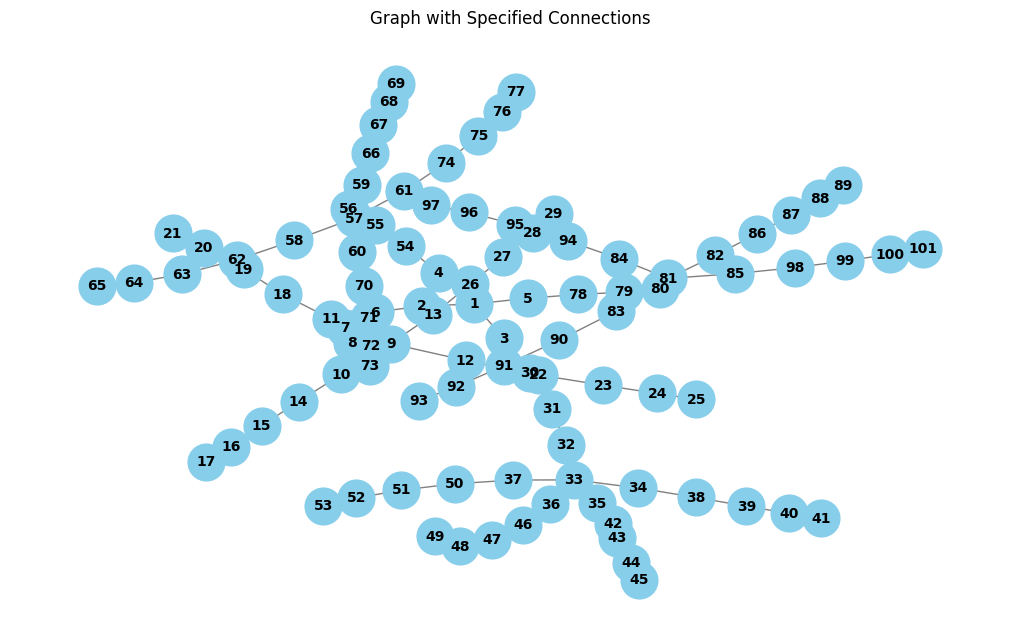

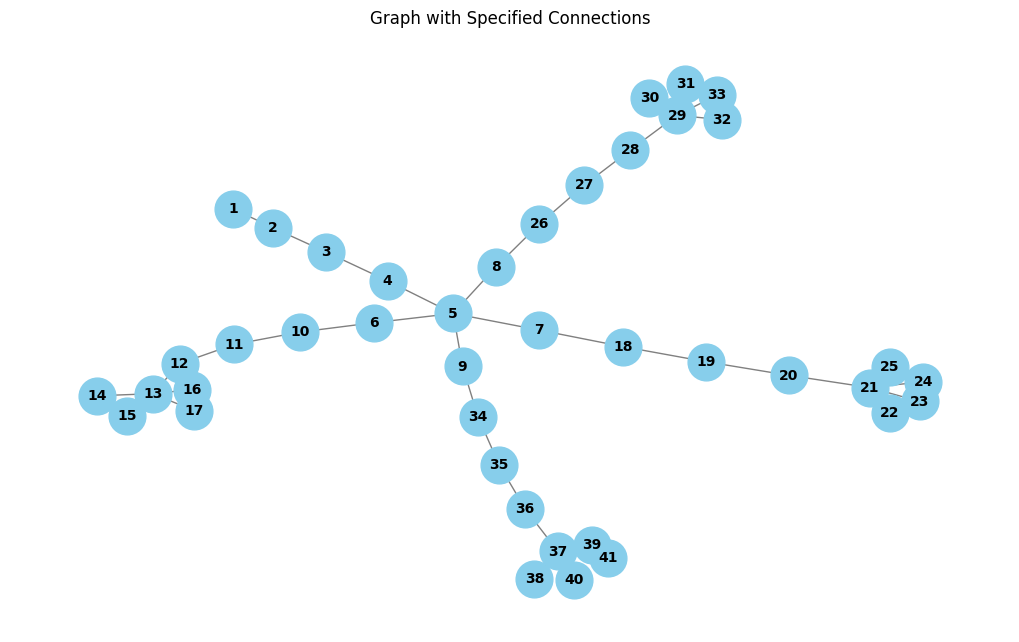

In [5]:
import random

class NeuronFactory:
    def __init__(self, complexity=3, intensity=0.1, signal_lenght=18):
        self.complexity = complexity
        self.receptors = {
            "f": lambda x, y: not (x ^ y),  # XNOR
            "t": lambda x, y: x and y,      # AND
            "s": lambda x, y: y,            # node signal
            "n": lambda x, y: x             # input signal
        }
        self.intensity = intensity
        self.graph = Graph()
        self.signal_lenght = signal_lenght

    def _random_signal(self):
        length = self.signal_lenght
        return [random.choice([0, 1]) for _ in range(length)]

    def _append_chain(self, cf, start_depth):
        """Private method to append a chain of nodes of a given function type."""
        end_depth = start_depth
        for i in range(self.complexity):
            current_depth = self.graph.add_node(signal=self._random_signal(), intensity=self.intensity, cf=self.receptors[cf])
            self.graph.add_edge(end_depth, current_depth)
            end_depth = current_depth
        return end_depth

    def _branch_nodes(self, cf, start_depth):
        """Private method to branch out nodes of a given function type."""
        end_nodes = []
        for i in range(self.complexity):
            current_depth = self.graph.add_node(signal=self._random_signal(), intensity=self.intensity, cf=self.receptors[cf])
            self.graph.add_edge(start_depth, current_depth)
            end_nodes.append(current_depth)
        return end_nodes

    def build_graph(self, function_stack=['n', 't', 'f', 's'], introverted=True):
        """Builds a neuron graph based on the function stack and introverted/extroverted structure."""

        # Start with the first node in the function stack
        self.graph.add_node(signal=self._random_signal(), intensity=self.intensity, cf=self.receptors[function_stack[0]])

        if introverted:
            # Introverted chain configuration
            node = self._append_chain(function_stack[0], start_depth=1)
            end_nodes = self._branch_nodes(function_stack[1], node)
            for end_node in end_nodes:
                final_node = self._append_chain(function_stack[2], end_node)
                self._branch_nodes(function_stack[3], final_node)
        else:
            # Extroverted chain configuration
            end_nodes = self._branch_nodes(function_stack[0], start_depth=1)
            for end_node in end_nodes:
                node = self._append_chain(function_stack[1], end_node)
                final_nodes = self._branch_nodes(function_stack[2], node)
                for final in final_nodes:
                    self._append_chain(function_stack[3], final)

        return self.graph

# Example usage
neuron = NeuronFactory(4)
graph = neuron.build_graph(introverted=False)
graph.display()

neuron2 = NeuronFactory(4)
graph2 = neuron2.build_graph(introverted=True)
graph2.display()


#Brain Builder

Builds a network of a brain where each node of higher order neuron can be connected to lower neuron (neuron with elements 1,2,3,4 will create a connection to 4 lower neurons 1- neuron1, 2- neuron2, 3-neuron3 and 4-neuron4 recursivly for any parameter of depth)

function_stack is a list of functions from top to bottom (highest will be fist elements in the list and lowest last elements in the list)

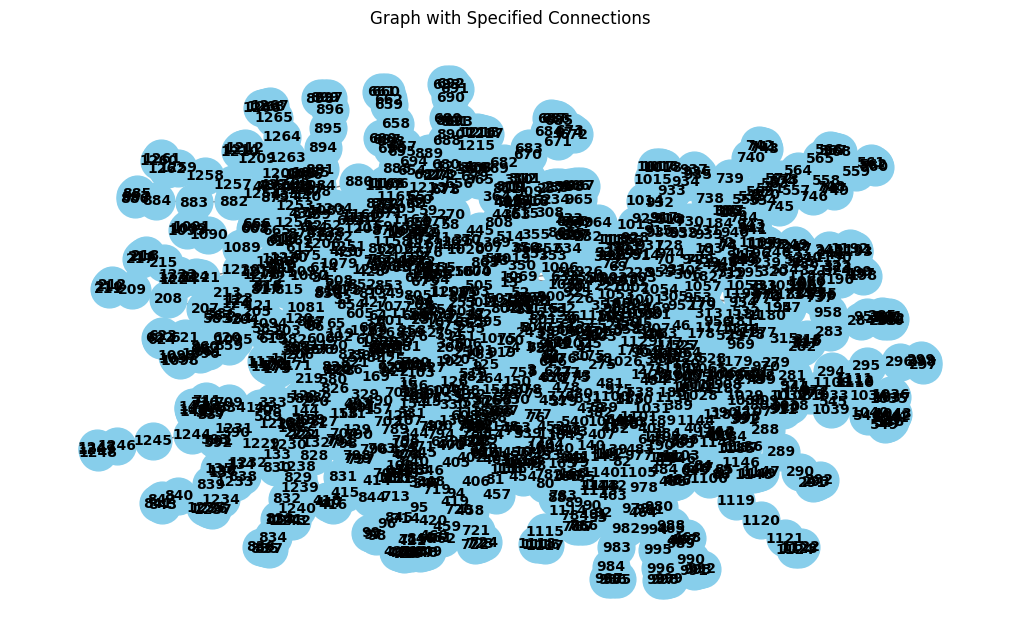

In [6]:
class BrainBuilder():
    def __init__(self, depth, function_stacks):
        self.depth= depth
        self.function_stacks= function_stacks
        self.neurons_covered = []

    def builder(self, input_signal):
        nf = NeuronFactory().build_graph(function_stack=self.function_stacks[0], introverted = False)
        for i in range(self.depth-1):
            nf = self.recursiveBuilder(nf, self.function_stacks[i])
        return nf

    def recursiveBuilder(self, nf, functions):
        Factory = NeuronFactory()
        nf_copy = nf.clone()
        for neuron_id in nf.nodes.keys():
            if neuron_id not in self.neurons_covered:
                #add introverted/extroverted
                new_graph= Factory.build_graph(function_stack=functions)
                Factory.graph = Graph()
                num = nf_copy.current
                nf_copy.merge_graph(new_graph)
                nf_copy.add_edge(neuron_id,num+1)
                self.neurons_covered.append(neuron_id)
        return nf_copy

brain = BrainBuilder(2,[['n', 't', 'f', 's'],['s', 'f', 't', 'n']])
brain_graph = brain.builder([0,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
brain_graph2 = brain.builder([0,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
brain_graph.display()

#Traverse Brain

 TraverseBrain is a learning algorithm designed to navigate and adjust a neural graph structure adaptively.
It performs traversal based on a combination of signals, connection functions, and neuron intensity to generate an output,
and applies a feedback mechanism for learning and penalization.

Attributes:
*   graph (Graph): The neural graph to be traversed.
*   learning_rate (float): Rate at which the neurons' intensities adjust during training.
*   adaptivness (float): Controls the degree to which the algorithm adjusts to new information.
*   temperature (float): Governs the probability of selecting a non-optimal path, supporting exploration.
*   penalization_rate (float): Rate at which neuron intensity decreases for penalized neurons.

In [7]:
import random

class TraverseBrain():
    def __init__(self, graph, learning_rate = 0.01,adaptivness = 0.1, temperature =0.9, penalization_rate = 10):
        self.learning_rate = learning_rate
        self.adaptivness = adaptivness
        self.temperature = temperature
        self.penalization_rate = penalization_rate
        self.graph = graph

    def __call__(self,input_signal):
        neurons = [self.graph.nodes[i] for i in self.traverse(input_signal)]
        self.train(input_signal,neurons)
        output = self.apply(input_signal,neurons)

        return output

    def apply_function_to_list(self, list1, list2, func):
        return [func(x,y) for x,y in zip(list1, list2)]

    def apply(self, input_signal, passed):
        for ele in passed:
            input_signal = self.apply_function_to_list(input_signal,ele['signal'],ele['cf'])
        return input_signal

    def train(self, signal, neurons):
        for neuron in neurons:
            neuron['intensity'] += self.learning_rate

    def penalize(self, input_signal):
        neurons = [self.graph.nodes[i] for i in self.traverse(input_signal)]
        for neuron in neurons:
            neuron['intensity'] -= self.learning_rate*self.penalization_rate

    def normilize(self):
        for neuron_id in self.graph.nodes:
            neuron = self.graph.nodes[neuron_id]
            neuron['intensity'] -= self.learning_rate
            if neuron['intensity'] < self.learning_rate:
                neuron['intensity'] = self.learning_rate


    def traverse(self, input_value):
        passed = []
        current = 1
        max_value = float('-inf')

        while current is not None:
            passed.append(current)
            next_node = None

            for neighbor_id in self.graph.edges[current]:
                neighbor = self.graph.nodes[neighbor_id]
                value = sum(self.apply_function_to_list(input_value,neighbor['signal'],neighbor['cf'])) * neighbor['intensity']

                if value > max_value or random.random()>self.temperature:
                    max_value = value
                    next_node = neighbor_id
                    if random.random()>self.temperature:
                        break

            current = next_node  # Move to the node with the highest 'cf' output

        return passed  # Return the path taken


learning_algo = TraverseBrain(brain_graph)
learning_algo2 = TraverseBrain(brain_graph2)

In [8]:
print(graph.nodes[1])
print(graph.edges[1])

{'signal': [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1], 'intensity': 0.1, 'cf': <function NeuronFactory.__init__.<locals>.<lambda> at 0x790f111b9c60>}
[2, 3, 4, 5]


In [9]:
class IksOksGame:
    def __init__(self):
        # Initialize empty board (00 = empty, 01 = O, 10 = X)
        self.board = [[0, 0] for _ in range(9)]
        self.current_player = [1, 0]  # Start with X (10)
        self.moves_history = []

    def print_board(self):
        symbols = {
            (0, 0): '-',  # Empty
            (0, 1): 'O',  # O player
            (1, 0): 'X'   # X player
        }

        print("\nCurrent board:")
        for i in range(3):
            row = []
            for j in range(3):
                cell = tuple(self.board[i * 3 + j])
                row.append(symbols[cell])
            print(" ".join(row))
        print()

    def get_binary_board(self):
        return [bit for cell in self.board for bit in cell]

    def is_valid_move(self, position):
        if not (0 <= position < 9):
            return False
        return self.board[position] == [0, 0]

    def make_move(self, position):
        if not self.is_valid_move(position):
            return False

        self.board[position] = self.current_player.copy()
        self.moves_history.append((position, self.current_player.copy()))
        # Switch player (10 -> 01 or 01 -> 10)
        self.current_player = [1 - self.current_player[0], 1 - self.current_player[1]]
        return True

    def try_ml_move(self, proposed_board):
        """
        Try to make a move based on the proposed board state from ML model.
        Returns True if the move was valid and made, False otherwise.
        """
        if len(proposed_board) != 18:  # 9 cells × 2 bits
            print("Invalid board length")
            return False

        # Convert to list of pairs
        proposed = [[proposed_board[i], proposed_board[i+1]] for i in range(0, 18, 2)]

        # Find the difference between current and proposed board
        for i in range(9):
            if proposed[i] != self.board[i]:
                if proposed[i] == self.current_player and self.board[i] == [0, 0]:
                    return self.make_move(i)

        print("Invalid move proposed")
        return False

    def check_winner(self):
        # Winning combinations
        lines = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6]              # Diagonals
        ]

        for line in lines:
            if (self.board[line[0]] == self.board[line[1]] == self.board[line[2]] != [0, 0]):
                return tuple(self.board[line[0]])

        # Check for draw
        if all(cell != [0, 0] for cell in self.board):
            return 'draw'

        return None

game = IksOksGame()

In [11]:
def Learn():
    game = IksOksGame()
    normalization_factor = 5
    counter = 0
    while True:
        counter+=1
        if counter ==normalization_factor:
            counter = 0
            learning_algo.normilize()
            learning_algo2.normilize()
        game.print_board()
        winner = game.check_winner()
        print(winner)
        if winner:
            if winner == 'draw':
                print("Game ended in a draw!")
            else:
                symbol = 'X' if winner == (1, 0) else 'O'
                print(f"Player {symbol} wins!")
                if symbol == 'X':
                    learning_algo2.penalize(game.get_binary_board())
                    learning_algo.normilize()
                    learning_algo2.normilize()
                if symbol == 'O':
                    learning_algo.penalize(game.get_binary_board())
                    learning_algo.normilize()
                    learning_algo2.normilize()
            break

        current_symbol = 'X' if game.current_player == [1, 0] else 'O'
        print(f"Current player: {current_symbol}")
        print(f"Binary board state: {game.get_binary_board()}")
        if current_symbol == 'X':
            binary_input = learning_algo(game.get_binary_board())
            success = game.try_ml_move(binary_input)
            if not success:
                learning_algo.penalize(game.get_binary_board())
        if current_symbol =='O':
            binary_input = learning_algo2(game.get_binary_board())
            success = game.try_ml_move(binary_input)
            if not success:
                learning_algo2.penalize(game.get_binary_board())
for i in range(100):
    print(f"\n\n\n\n\nEPOH{i}\n\n\n\n\n")
    Learn()

Streaming output truncated to the last 5000 lines.

Current board:
- - -
- - -
- - -

None
Current player: X
Binary board state: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Invalid move proposed

Current board:
- - -
- - -
- - -

None
Current player: X
Binary board state: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Invalid move proposed

Current board:
- - -
- - -
- - -

None
Current player: X
Binary board state: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Invalid move proposed

Current board:
- - -
- - -
- - -

None
Current player: X
Binary board state: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Invalid move proposed

Current board:
- - -
- - -
- - -

None
Current player: X
Binary board state: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Invalid move proposed

Current board:
- - -
- - -
- - -

None
Current player: X
Binary board state: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Invalid move proposed

Current board:
- -

KeyboardInterrupt: 

In [ ]:
for i in range(10):
    print(learning_algo.graph.nodes[i+1])

In [ ]:
def play():
    game = IksOksGame()
    chosen_simbol = '0'
    if chosen_simbol not in ['X', 'O']:
        chosen_simbol = input("choose simbol:")
    while True:
        game.print_board()
        winner = game.check_winner()
        print(winner)
        if winner:
            if winner == 'draw':
                print("Game ended in a draw!")
            else:
                symbol = 'X' if winner == (1, 0) else 'O'
                print(f"Player {symbol} wins!")
                if symbol != chosen_simbol:
                    learning_algo.penalize(game.get_binary_board())
                    learning_algo.normilize()
            break

        current_symbol = 'X' if game.current_player == [1, 0] else 'O'
        print(f"Current player: {current_symbol}")
        print(f"Binary board state: {game.get_binary_board()}")
        if current_symbol != chosen_simbol:
            binary_input = learning_algo(game.get_binary_board())
            success = game.try_ml_move(binary_input)
            if not success:
                learning_algo.penalize(game.get_binary_board())
        if current_symbol == chosen_simbol:
            try:
                choice = input("Enter position (0-8):")
                position = int(choice)
                if not game.make_move(position):
                    print("Invalid move, try again")
            except ValueError:
                print("Invalid input, try again")

play()